# High-level Caffe2 MNIST Example

In [1]:
%matplotlib inline
import numpy as np
import sklearn.preprocessing
import os
from matplotlib import pyplot
from IPython import display
from caffe2.python import core, model_helper, net_drawer, workspace, visualize, brew, optimizer, utils
from caffe2.proto import caffe2_pb2
from keras.datasets import mnist  # Only to import MNIST data

Using CNTK backend


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Cast to caffe2 compatible
x_train = np.array(x_train, dtype=np.float32) / 256
x_test = np.array(x_test, dtype=np.float32) / 256
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)
# Reshape to [N, C, H, W]
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)
print(x_train.shape)
print(x_test.shape)
print(x_train.dtype)
print(y_train.dtype)

(60000, 1, 28, 28)
(10000, 1, 28, 28)
float32
int32


In [3]:
# Hyperparams
device_opts = core.DeviceOption(caffe2_pb2.CUDA, 0)  # Run on GPU
#device_opts = core.DeviceOption(caffe2_pb2.CPU, 0)  # Run on CPU
epochs = 12
batchsize = 32
n_classes = 10

In [4]:
def create_model(m, device_opts) :
    with core.DeviceScope(device_opts):
        # Image size: 28 x 28 -> 24 x 24
        conv1 = brew.conv(m, 'data', 'conv1', dim_in=1, dim_out=20, kernel=5)
        # Image size: 24 x 24 -> 12 x 12
        pool1 = brew.max_pool(m, conv1, 'pool1', kernel=2, stride=2)
        # Image size: 12 x 12 -> 8 x 8
        conv2 = brew.conv(m, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
        # Image size: 8 x 8 -> 4 x 4
        pool2 = brew.max_pool(m, conv2, 'pool2', kernel=2, stride=2)
        # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
        fc3 = brew.fc(m, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
        fc3 = brew.relu(m, fc3, fc3)
        pred = brew.fc(m, fc3, 'pred', 500, n_classes)
        softmax = brew.softmax(m, pred, 'softmax')
        return softmax

In [5]:
def add_training_operators(softmax, model, device_opts) :
    with core.DeviceScope(device_opts):
        xent = model.LabelCrossEntropy([softmax, "label"], 'xent')
        loss = model.AveragedLoss(xent, "loss")
        brew.accuracy(model, [softmax, "label"], "accuracy")

        model.AddGradientOperators([loss])
        opt = optimizer.build_sgd(
            model,
            base_learning_rate=0.01, 
            policy='fixed',
            momentum=0.9)
        #opt = optimizer.build_adam(model, base_learning_rate=0.001)
        #opt = optimizer.build_sgd(model, base_learning_rate=0.01)

In [6]:
def yield_mb(X, y, batchsize=64):
    assert len(X) == len(y)
    # Only complete batches are submitted
    for i in range(len(X)//batchsize):
        yield X[i*batchsize:(i+1)*batchsize], y[i*batchsize:(i+1)*batchsize]

In [7]:
# Create Place-holder for data
for data, label in yield_mb(x_train, y_train, batchsize):
    print(data.shape)
    print(label.shape)
    print(label)
    break
    
workspace.FeedBlob("data", data, device_option=device_opts)
workspace.FeedBlob("label", label, device_option=device_opts)

(32, 1, 28, 28)
(32,)
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8]


True

In [8]:
# Initialise 
train_model= model_helper.ModelHelper(name="train_net")
softmax = create_model(train_model, device_opts=device_opts)
add_training_operators(softmax, train_model, device_opts=device_opts)

workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net)

True

In [9]:
%%time

# Train
total_iters = (len(x_train)//batchsize)*epochs
loss = np.zeros(total_iters)
c = 0

for j in range(epochs):
    for data, label in yield_mb(x_train, y_train, batchsize):
        # Run one min-batch
        workspace.FeedBlob("data", data, device_option=device_opts)
        workspace.FeedBlob("label", label, device_option=device_opts)
        workspace.RunNet(train_model.net, 1)
        loss[c] = workspace.FetchBlob('loss')
        c+= 1
        
    print("Finished epoch: ", j)
    print(str(j) + ': ' + str(workspace.FetchBlob("loss")))

Finished epoch:  0
0: 0.02713099680840969
Finished epoch:  1
1: 0.00245861173607409
Finished epoch:  2
2: 0.00026570609770715237
Finished epoch:  3
3: 0.00016440160106867552
Finished epoch:  4
4: 0.000303918233839795
Finished epoch:  5
5: 2.8865648346254602e-05
Finished epoch:  6
6: 0.00018870935309678316
Finished epoch:  7
7: 9.760783541423734e-06
Finished epoch:  8
8: 1.5010802599135786e-05
Finished epoch:  9
9: 8.060461368586402e-06
Finished epoch:  10
10: 1.119515309255803e-05
Finished epoch:  11
11: 5.875043825653847e-06
Wall time: 1min 27s


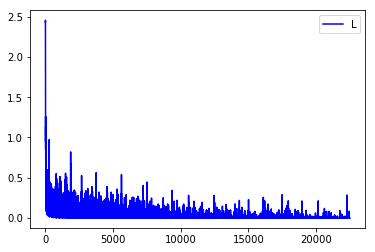

In [10]:
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.legend(('Loss'), loc='upper right')

In [11]:
# Test model
test_model= model_helper.ModelHelper(name="test_net", init_params=False)
create_model(test_model, device_opts=device_opts)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

True

In [12]:
# Test one-minibatch
y_guess = np.zeros(y_test.shape, dtype=np.int)
y_truth = np.zeros(y_test.shape, dtype=np.int)
c = 0
for data, label in yield_mb(x_test, y_test, batchsize):
    workspace.FeedBlob("data", data, device_option=device_opts)
    workspace.RunNet(test_model.net, 1)
    y_guess[c*batchsize:(c+1)*batchsize] = (np.argmax(workspace.FetchBlob("softmax"), axis=-1))
    y_truth[c*batchsize:(c+1)*batchsize] = y_test[c*batchsize:(c+1)*batchsize]
    c += 1

In [13]:
print("Accuracy: ", sum(y_guess == y_truth)/len(y_guess))

Accuracy:  0.991
